In [27]:
import tensorflow.compat.v1 as tf
import scipy.io
import numpy as np
import os
import random
import math
import pandas as pd
import seaborn as sns
#from skimage.measure import structural_similarity as ssim
#from sporco import util
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV, RFE
import multiprocessing
import datetime
import hdf5storage

In [28]:
def fnn(x, input_size, output_size, keep_prob, stddev=0.01, constant=0.0001, dropout=True, end=False):
    fc_w = tf.Variable(tf.truncated_normal([input_size,output_size], stddev=stddev,seed=np.random.seed(2018)))
    fc_b = tf.Variable(tf.constant(constant,shape=[output_size]), dtype=tf.float32)
    fc_h = tf.nn.relu(tf.matmul(x,fc_w)+fc_b) if not end else tf.matmul(x,fc_w)+fc_b
    return tf.nn.dropout(fc_h, keep_prob,seed=np.random.seed(2018)) if dropout else fc_h

In [29]:
def fcn(x, input_size, output_size, nlayers, nparameters, keep_prob):
    if nlayers == 1:
        h1 = fnn(x, input_size, output_size, keep_prob, end=True)
    elif nlayers == 2:
        h1 = fnn(fnn(x, input_size, nparameters, keep_prob, end=False), nparameters, output_size, keep_prob, end=True)
    elif nlayers >= 3:
        h0 = fnn(x, input_size, nparameters, keep_prob, end=False)
        for j in range(0,nlayers-2):
            if j == 0:
                h1 = fnn(h0, nparameters, nparameters, keep_prob, end=False)
            else:
                h1 = fnn(h1, nparameters, nparameters, keep_prob, end=False)
        h1 = fnn(h1, nparameters, output_size, keep_prob, end=True)
    else:
        print("# of layers can't be smaller than 0")
    return h1

In [30]:
def rfc(train_data, train_label, test_data, test_label):
    rf = RandomForestClassifier(n_estimators=150,
                                    criterion='gini',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=-1,
                                    random_state=123,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None)
    rf.fit(train_data, train_label.ravel())
    result = rf.predict_proba(test_data)
    acc = 0.0
    for i in range(np.shape(test_data)[0]):
        r = np.argmax(result[i])
        if r == test_label[i]:
            acc += 1
    acc /= np.shape(test_data)[0]
    acc *= 100
    return acc, result

In [31]:
def dnn(train_data, train_label, test_data, test_label):
    g = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    batch_size = 10
    input_size = np.shape(train_data)[1]
    output_size = 31

    with g.as_default():
        p_x = tf.placeholder(tf.float32, [batch_size, 1, input_size, 1])
        p_y = tf.placeholder(tf.float32, [batch_size, output_size])
        keep_prob = tf.placeholder(tf.float32)
        h10_flat = tf.reshape(p_x, [batch_size,-1])
        h1 = fnn(h10_flat, input_size, 2048, keep_prob, end=False)
        h2 = fnn(h1, 2048, 2048, keep_prob, end=False)
        h3 = fnn(h2, 2048, 31, keep_prob, end=True)
        h4 = tf.reshape(h3, [batch_size, 31])
        h_c = tf.nn.softmax(h4)
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=p_y, logits=h4))
        optim = tf.train.AdamOptimizer(1e-5)
        trainer = optim.minimize(loss)
    
    accuracy = 0.0
    result = np.zeros([np.shape(test_data)[0], 31])
    with tf.Session(graph=g, config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(0,120):
            loss_tot = 0.0
            for i in range(0,int(np.ceil(np.shape(train_data)[0]/batch_size))):
                a = np.random.randint(0,np.shape(train_data)[0],size=batch_size)
                x = train_data[a].reshape([batch_size, 1, input_size, 1])#[4,1,18181,1]
                y = np.zeros([batch_size, output_size])
                index = train_label[a]
                for u in range(0,batch_size):
                    y[u,index[u]] = 1
                _ , loss_val = sess.run([trainer, loss], feed_dict={p_x:x, p_y:y, keep_prob:0.6})
                loss_tot += loss_val
            print("%d epoch Loss: %f" % (e,(loss_tot)/np.shape(train_data)[0]))
        temp = 0
        for i in range(0,int(np.floor(np.shape(test_data)[0]/batch_size))):
            x = test_data[i*batch_size:(i+1)*batch_size].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0, batch_size):
                t = np.squeeze(out[j])
                result[temp] = t
                temp+=1
        remain = int(np.shape(test_data)[0]-np.floor(np.shape(test_data)[0]/batch_size)*batch_size)
        if remain > 0:
            x = test_data[-batch_size-1:-1].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0,int(remain)):
                t = np.squeeze(out[j+(batch_size-remain)])
                result[temp] = t
                temp+=1
        for i in range(0,np.shape(test_data)[0]):
            ind = np.argmax(np.squeeze(result[i]))
            if ind == test_label[i]:
                accuracy += 1
        accuracy /= np.shape(test_data)[0]*0.01
        sess.close()
    return accuracy, result

In [32]:
dataID = hdf5storage.loadmat('data.mat')
data = np.array(dataID['data'], dtype=np.float32)
gt1 = scipy.io.loadmat('label.mat')
label = np.array(gt1['label'], dtype=np.int32)

In [33]:
Outer_loop = 1
Inner_loop = 1

In [34]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        #lasso = Lasso()
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        coefidx = np.argsort(coef)

        u = np.sum(tot_acc,0)
        
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        print(tr_data)
        print(te_data)
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[]
[[ 0.00000000e+00  0.00000000e+00  3.48899990e-01 ...  2.26190478e-01
   1.90476194e-01  2.47832492e-01]
 [ 0.00000000e+00  0.00000000e+00 -9.88999978e-02 ...  2.13592231e-01
   1.74757287e-01  3.28941315e-01]
 [ 0.00000000e+00  0.00000000e+00  3.07000000e-02 ...  2.28571430e-01
   5.71428575e-02  1.21663220e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  3.29999998e-03 ...  5.94594598e-01
   1.35135129e-01  1.53205544e-01]
 [ 0.00000000e+00  0.00000000e+00  3.00000014e-04 ...  1.17647059e-01
   3.52941185e-01  1.17157176e-01]
 [ 0.00000000e+00  0.00000000e+00 -7.37000033e-02 ...  1.34328365e-01
   1.04477614e-01  2.61350632e-01]]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_

ZeroDivisionError: float division by zero

In [25]:
def KNN(train_data, train_label, test_data, test_label):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(train_data, train_label.ravel())
    result = rf.predict_proba(test_data)
    acc = 0.0
    for i in range(np.shape(test_data)[0]):
        r = np.argmax(result[i])
        if r == test_label[i]:
            acc += 1
    acc /= np.shape(test_data)[0]
    acc *= 100
    return acc, result

In [22]:
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        coefidx = np.argsort(coef)

        
        u = np.sum(tot_acc,0)
        
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [26]:
te_data

array([[ 0.00000000e+00,  0.00000000e+00,  3.48899990e-01, ...,
         2.26190478e-01,  1.90476194e-01,  2.47832492e-01],
       [ 0.00000000e+00,  0.00000000e+00, -9.88999978e-02, ...,
         2.13592231e-01,  1.74757287e-01,  3.28941315e-01],
       [ 0.00000000e+00,  0.00000000e+00,  3.07000000e-02, ...,
         2.28571430e-01,  5.71428575e-02,  1.21663220e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  3.29999998e-03, ...,
         5.94594598e-01,  1.35135129e-01,  1.53205544e-01],
       [ 0.00000000e+00,  0.00000000e+00,  3.00000014e-04, ...,
         1.17647059e-01,  3.52941185e-01,  1.17157176e-01],
       [ 0.00000000e+00,  0.00000000e+00, -7.37000033e-02, ...,
         1.34328365e-01,  1.04477614e-01,  2.61350632e-01]], dtype=float32)

In [12]:
from sklearn.metrics import accuracy_score

In [14]:
def KNN(train_data, train_label, test_data, test_label):
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_data, train_label.ravel())
    #result = rf.predict_proba(test_data)
    label_pred = knn.predict(test_data)
    
    return accuracy_score(test_label, label_pred)

In [15]:
KNN_acc= KNN(tr_data, train_label, te_data, test_label)

ValueError: Found array with 0 sample(s) (shape=(0, 4000)) while a minimum of 1 is required.

In [26]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        coefidx = np.argsort(coef)

        
        u = np.sum(tot_acc,0)
        
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        #nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        KNN_acc, result_KNN = KNN(tr_data, train_label, te_data, test_label)
        print(ovr_svm_acc)
#         en_acc = 0.0
#         for i in range(0,np.shape(te_data)[0]):
#             r = np.argmax(result_nn[i]+result_rf[i])
#             if r == test_label[i]:
#                 en_acc += 1
#         en_acc /= np.shape(te_data)[0]*0.01
#         print("Outer_fold # of features:  %d, Neural network accuracy: %f, KNN accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, KNN_acc, en_acc))
#         flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


ValueError: Found array with 0 sample(s) (shape=(0, 4000)) while a minimum of 1 is required.

In [ ]:
dataID = hdf5storage.loadmat('data.mat')
data = np.array(dataID['data'], dtype=np.float32)
gt1 = scipy.io.loadmat('label.mat')
label = np.array(gt1['label'], dtype=np.int32)

In [ ]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
X = np.array([
     [10, 10],
     [8, 10],
     [-5, 5.5],
     [-5.4, 5.5],
     [-20, -20],
     [-15, -20]
 ])
y = np.array([0, 0, 1, 1, 2, 2])
clf = OneVsRestClassifier(SVC()).fit(data, label)
#result = rf.predict_proba(test_data)
clf.predict_proba(test_data)



In [ ]:
clf.predict([[-19, -20], [9, 9], [-5, 5]])

In [9]:
data = {'Accuracy':MD_acc,'Feature Select':MD_sel, 'Model':MD_md}

In [10]:
df = pd.DataFrame(data)
df

,Accuracy,Feature Select,Model
0,80.571429,no select,ensemble
1,79.571429,no select,ensemble
2,80.571429,no select,ensemble
3,79.285714,no select,ensemble
4,79.571429,no select,ensemble
...,...,...,...
115,72.857143,lsvc,random forest
116,72.714286,lsvc,random forest
117,75.714286,lsvc,random forest
118,74.000000,lsvc,random forest


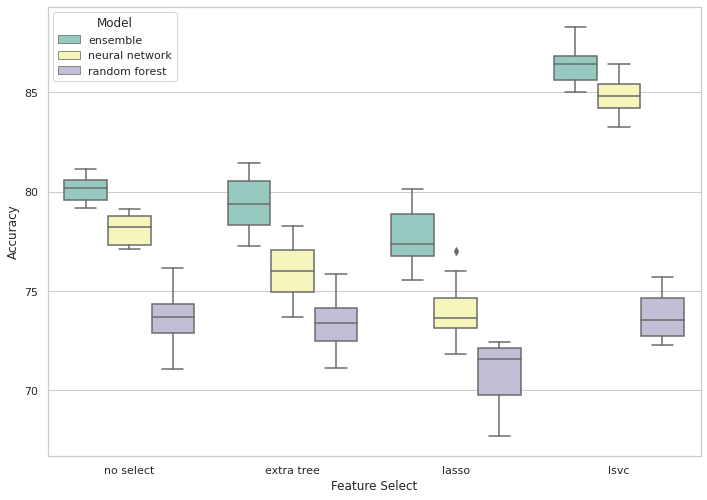

In [11]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.boxplot(x = "Feature Select", y = "Accuracy", hue="Model", data = df, palette = "Set3")